In [1]:
import cv2
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import math
import os


## Lucas Kanade

**About:** The method works by assuming that the flow in a local neighbourhood of the pixel under examination is essentially constant, and then solving the basic optical flow equations for all the pixels in that neighbourhood using the least squares criterion.

The Lucas–Kanade approach may typically resolve the inherent ambiguity of the optical flow equation by merging information from multiple neighbouring pixels. It's also less affected by image noise than point-based approaches. Yet, because it is a strictly local method, it cannot offer flow information in the interior of uniform portions of the image; however, once the region has been specified, it can be optimised.

**Implemetation:** 

Within a neighbourhood of the point p under examination, the Lucas–Kanade approach implies that the displacement of picture contents between two neighbouring instants (frames) is minimal and approximately constant. As a result, in a given window size w, the optical flow equation can be considered to be true. Assuming that Vx and Vy move the points in opposite directions, we can deduce the following equations:

    I x ( q 1 ) V x + I y ( q 1 ) V y = − I t ( q 1 )

    I x ( q 2 ) V x + I y ( q 2 ) V y = − I t ( q 2 ) 
    .......
    .......
    .......
    I x ( q n ) V x + I y ( q n ) V y = − I t ( q n )
    
    where q 1 , q 2 , … , q n are the pixels inside the window
  So the equations can be represented as  a matrix where
   ![](https://wikimedia.org/api/rest_v1/media/math/render/svg/4dba1d119546e8fe15ad701c99d0e32595f9a6c8)
    
    The problem can be now mapped to least square error as learnt in optimisation methods.
    
    So we can take the partial inverse and get equations like
   ![](https://wikimedia.org/api/rest_v1/media/math/render/svg/c0243b8dc5b55074c9a3a6c623970a60fbc13f86)
   
   The code implemented follows the steps as mentioned above

In [2]:
def display_opticalflow_results(im1,im2,u,v,fig_size=(16,16),arrow_thres=0.02):    
    fig = plt.figure(figsize=fig_size)
    
    #     Images
    ax = fig.add_subplot(3,2,1)
    ax.imshow(im1,cmap='gray')
    ax.set_title("Image T:1")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,2)
    ax.imshow(im2,cmap='gray')
    ax.set_title("Image T:2")
    ax.axis('off')
    
    # Vectors     
    ax = fig.add_subplot(3,2,3)
    ax.imshow(u,cmap='gray')
    ax.set_title("U")
    ax.axis('off')
    
    ax = fig.add_subplot(3,2,4)
    ax.imshow(v,cmap='gray')
    ax.set_title("V")
    ax.axis('off')
    
    # Magnitude     
    ax = fig.add_subplot(3,2,5)
    ax.imshow(u*u + v*v,cmap='gray')
    ax.set_title("U^2 + V^2")
    ax.axis('off')
    
    # Angle
    ax = fig.add_subplot(3,2,6)
    ax.imshow(np.arctan2(v,u),cmap='gray')
    ax.set_title("arc(v/u)")
    ax.axis('off')

    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(1,2,1)
    ax.imshow(im1,cmap='gray')
    ax.set_title("Optical flow Arrows")
    kp = cv2.goodFeaturesToTrack(im1, 100, 0.01, 10, 3)
    for arrow_ind in kp:
        x,y = arrow_ind[0]
        y = int(y)
        x = int(x)
        ax.arrow(x,y,u[y,x],v[y,x],head_width = 1, head_length = 5, color = (0,1,0))
        
    ax = fig.add_subplot(1,2,2)
    ax.imshow( (u*u + v*v>arrow_thres),cmap='gray')
    ax.set_title("Optical flow Mask")
    
    ax.axis('off')
   

    plt.show()

In [3]:
def optical_flow(img1, img2, window_size):
    tau=1e-2
    mode = 'same'
    x_kernel = np.array([[-1., 1.], [-1., 1.]])
    y_kernel = np.array([[-1., -1.], [1., 1.]])
    t_kernel = np.array([[1., 1.], [1., 1.]])
    w = window_size//2
    img1 = img1 / 255. 
    img2 = img2 / 255. 
    gradx = signal.convolve2d(img1, x_kernel, boundary='symm', mode=mode)
    grady = signal.convolve2d(img1, y_kernel, boundary='symm', mode=mode)
    gradt = signal.convolve2d(img2, t_kernel, boundary='symm', mode=mode) + signal.convolve2d(img1, -t_kernel, boundary='symm', mode=mode)
    u = np.zeros(img1.shape)
    v = np.zeros(img1.shape)
    row = img1.shape[0]
    col = img1.shape[1]
    for i in range(w, row-w):
        for j in range(w, col-w):
            start1 = i-w 
            end1 = i+w+1
            start2 = j-w
            end2 = j+w+1
            Ix = gradx[start1:end1, start2:end2].flatten()
            Iy = grady[start1:end1, start2:end2].flatten()
            It = gradt[start1:end1, start2:end2].flatten()
            sumxx = np.sum(Ix*Ix)
            sumxy = np.sum(Ix*Iy)
            sumyy = np.sum(Iy*Iy)
            sumxt = np.sum(Ix*It)
            sumyt = np.sum(Iy*It)
            A = [ [ sumxx,sumxy], [sumxy, sumyy] ]
            A = np.array(A)
            b = [-sumxt, -sumyt]
            b = np.array(b)
            temp = A.T.dot(A)
            U,D,V_T = np.linalg.svd(temp)
            
            if np.min(D) >= tau:    
                try:
                    nu = np.linalg.inv(A).dot(b)
                    u[i,j]=nu[0]
                    v[i,j]=nu[1]
                except Exception as e:
                    print(A,D,e)
            
            else:
                u[i,j]=0
                v[i,j]=0                
                
    return [u,v]

### Segmentation Using Optical Flow

For this part I have taken refernece from [this](https://arxiv.org/pdf/1807.04890.pdf) publication.

We define
**pt** as the set of points in the window

**Ft,Ft−k=Ht→Ft−k∗pt−pt**

In [4]:
def segmentation_as_time(im1,im2,threshold,iter =5):
    orb = cv2.ORB_create(500)
    keypoints1, descriptors1 = orb.detectAndCompute(im1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2, None)
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    matches.sort(key=lambda x: x.distance, reverse=False)
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
    h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)
    width = im1.shape[1]
    height = im1.shape[0]
    im2Reg = cv2.warpPerspective(im2, h, (width, height))
    im3 = im2Reg - im2    

    im4 = np.zeros(im2.shape)
    for i in range(im3.shape[0]):
        for j in range(im3.shape[1]):
            im4[i,j] = abs(math.cos(im2[i,j]-im3[i,j]))

    t = threshold

    for i in range(im4.shape[0]):
        for j in range(im4.shape[1]):
            if im4[i,j] < t:
                im4[i,j] = 1
            else:
                im4[i,j] = 0


    kernel = np.ones((4,4),np.uint8)
    im4 = cv2.dilate(im4,kernel,iterations = iter)
    plt.figure()
    plt.imshow(im4,cmap = 'gray')
    plt.show()


In [5]:
img_dir ='./Dataset/'
img_pair_list = []
for dirname in sorted(os.listdir(img_dir)):
    if os.path.isdir(os.path.join(img_dir,dirname)):
        im1_path,im2_path = os.listdir(os.path.join(img_dir,dirname))
        im1 = cv2.imread(os.path.join(img_dir,dirname,im1_path),0)
        im2 = cv2.imread(os.path.join(img_dir,dirname,im2_path),0)
        img_pair_list.append([im1,im2])

In the below plots the first two images are the two successive frame images and the last two images depicts the optical flow  arrows and optical flow mask respectively.

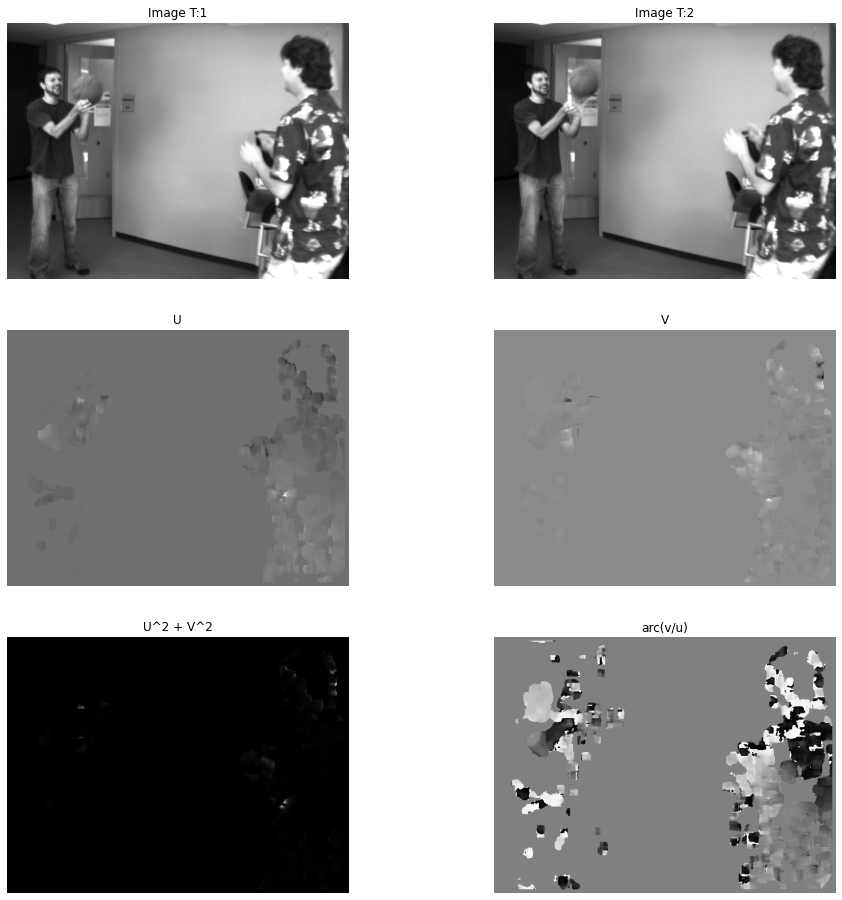

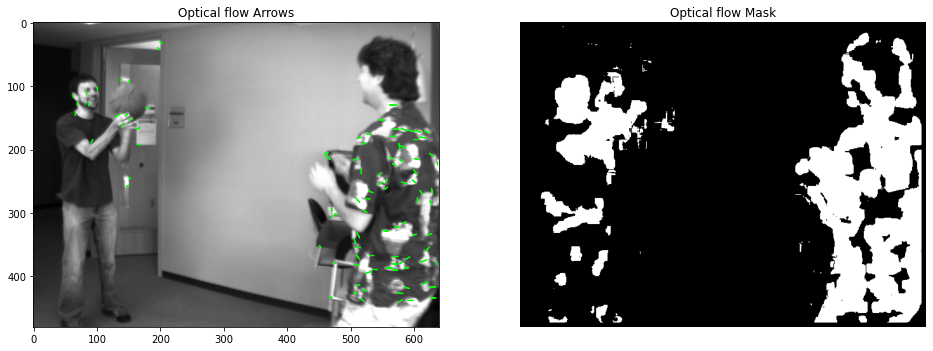

<ipython-input-4-b5a05c028110>:23: RuntimeWarning: overflow encountered in ubyte_scalars
  im4[i,j] = abs(math.cos(im2[i,j]-im3[i,j]))


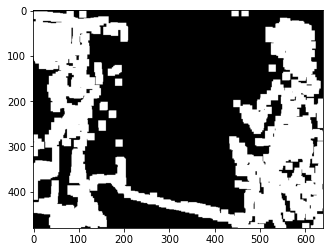

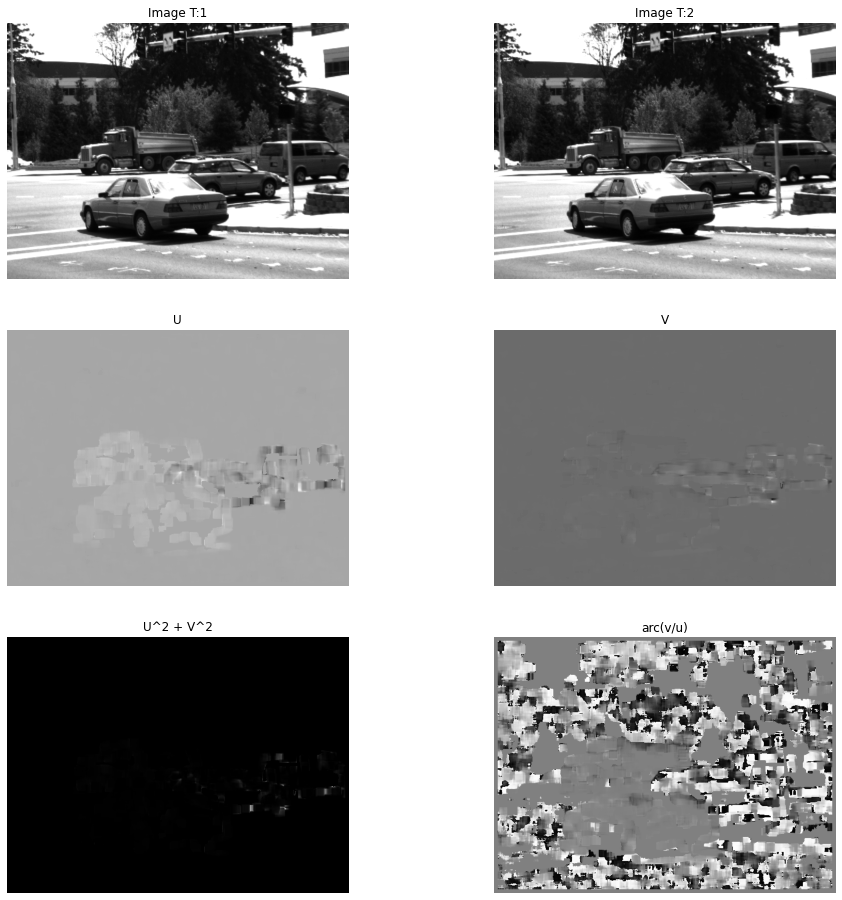

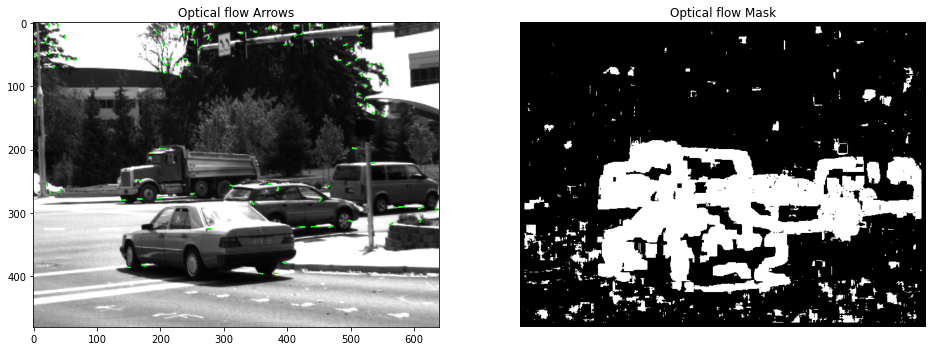

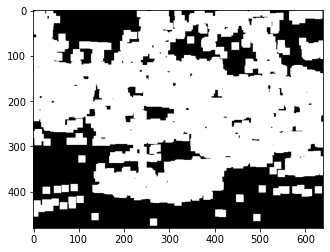

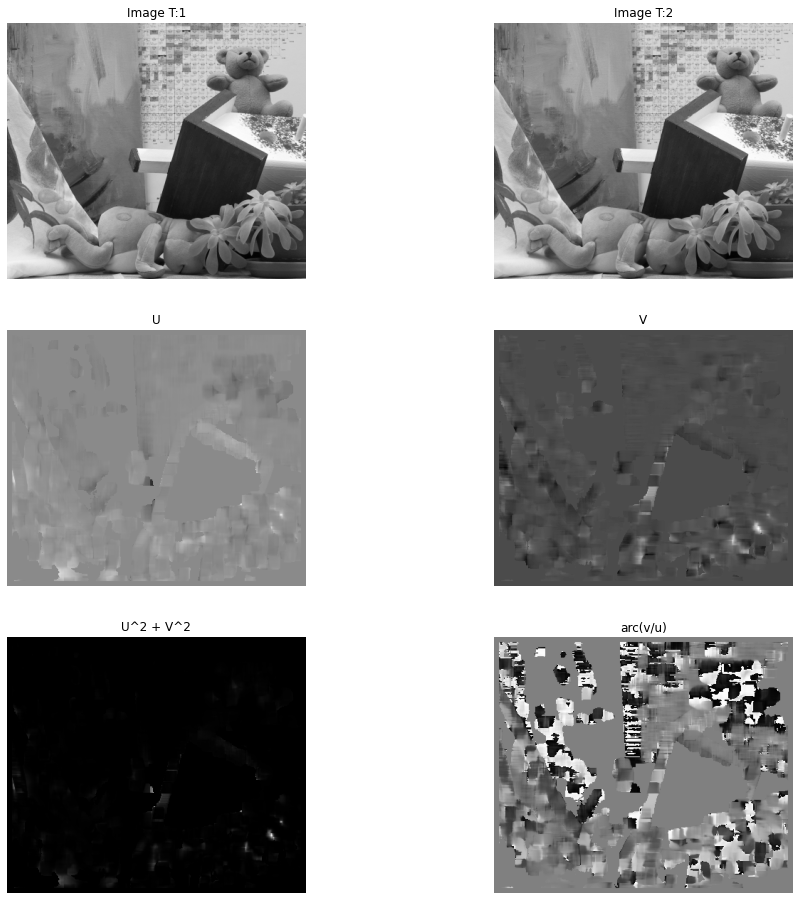

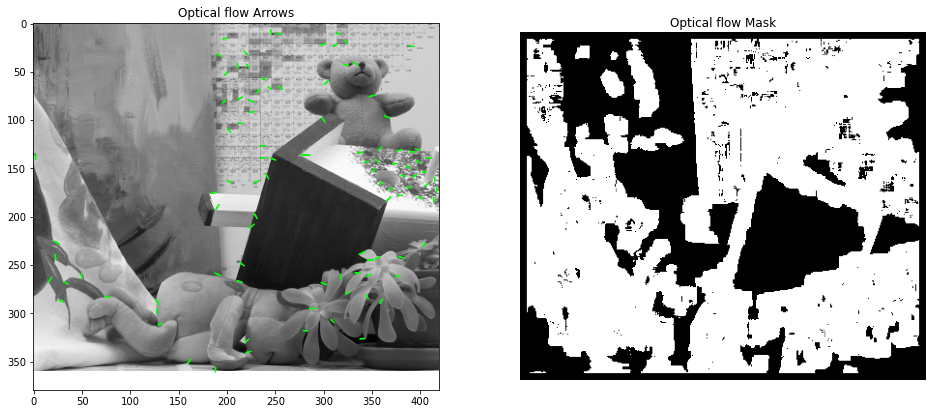

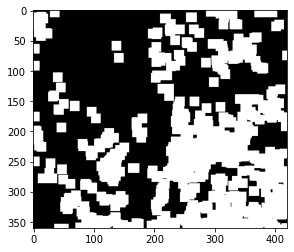

In [ ]:
for image_pair in img_pair_list:
    im1,im2 = image_pair
    u,v = optical_flow(im1,im2,window_size=15)
    display_opticalflow_results(im1,im2,u,v)
    segmentation_as_time(im1,im2,.03,5)

**Summary:** The images basically are frames from a video, the second images is certain frames ahead than its previous image. These frames helps the algorithm decide the flow of the image and plot the arrows in the required direction.

Same thing is done with the video input, two or more successive frames are selected from a video and the algorithm calculates the optical flow of the video frame.  